# Step 1: Setting up the dataset
The Image classification is uploaded as zip file and then extracted into a folder called dataset.

In [ ]:
!pip install split-folders

In [ ]:
data_path = '/content/Image_Classification.zip'

In [ ]:
import os
import zipfile

In [ ]:

dataset = 'dataset'

with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall(dataset)



for root, dirs, files in os.walk(dataset):
    for file in files:
        print(os.path.join(root, file))

dataset/Image_Classification/dataset_14334027/Border_terrier/30.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/141.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/90.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/160.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/112.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/170.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/34.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/150.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/128.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/08.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/17.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/74.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/73.jpg
dataset/Image_Classification/dataset_14334027/Border_terrier/37.jpg
dataset/Image_Classification/dataset_14334

# Step 2: Importing Modules

In [ ]:
import os
import shutil
import random
from pathlib import Path
import zipfile

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
import splitfolders as sf

# Step 3: Splitting the dataset

The dataset is split into train, validation and test sets using splitfolders into ratio of 70:15:15 respectively.

In [ ]:
input_folder = '/content/dataset/Image_Classification/dataset_14334027'

sf.ratio(input_folder, output="output",
    seed=14334027, ratio=(.7, .15, .15), group_prefix=None, move=False)

Copying files: 3118 files [00:00, 7758.64 files/s]


In [ ]:
train_dir = "/content/output/train"
validation_dir = "/content/output/val"
test_dir = "/content/output/test"

# Step 4: Defining data generator and implementing data preprocessing

In this code, here, we have implemented data augmentation for the train dataset, and have rescaled the images for all 3 sets train, val and test.

The data augmentation done on the training dataset, is as follows:
*   rescale=1./255: Normalizes pixel values from [0, 255] to [0, 1].
*   rotation_range=40: Randomly rotate images up to 40 degrees.
*   width_shift_range / height_shift_range=0.2: Randomly shift the image horizontally/vertically by 20% of the width/height.
*   shear_range=0.2: Apply shear transformation.
*   zoom_range=0.2: Random zoom in/out.
*   horizontal_flip=True: Randomly flip the image horizontally.
*   fill_mode='nearest': Strategy to fill in new pixels created during transformations.


For the testing and validation data generator, only rescaling is applied; no augmentation since we want to evaluate performance on the real, unmodified data.

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        class_mode='categorical'
        )


validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
       )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
)

Found 2174 images belonging to 20 classes.
Found 456 images belonging to 20 classes.
Found 488 images belonging to 20 classes.


# Step 5: Implementing Checkpointing and Earlystopping

Checkpointing: we save the best model according to the validation accuracy metric, we update the model every time we have better score.

Earlystopping: This will monitor the validation accuracy metric over 20 epcohs, if it does not improve we will stop training and restore the best weights.

In [ ]:
import math
from keras.optimizers import SGD, Adam, Adadelta
from keras.callbacks import LearningRateScheduler
from keras.activations import relu, softmax
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix

from keras.utils import plot_model

from IPython.display import HTML, display, clear_output, SVG

import warnings
warnings.filterwarnings("ignore")

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 20,
    restore_best_weights= True,
    mode = 'max',
    verbose=1
)

# Step 6: Importing the model and customizing the model

Here, we import the ResNet50 model, except the topmost layer, we make sure that no layers are frozen, we also get the pre-defined weights for the imagenet dataset.

Here we truncate the model by removing the 5th convolutional layer, and we also add a dropout of 0.5 before the final dense layer.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

resnetModel = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

for i, layer in enumerate(resnetModel.layers):
    print(i, layer.name)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
0 input_layer
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_

In [ ]:
previous_output = resnetModel.get_layer('conv4_block6_out').output

x = GlobalAveragePooling2D()(previous_output)
x = Dropout(0.5)(x)
output = Dense(20, activation='softmax')(x)


model = Model(inputs=resnetModel.input, outputs=output)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

for i, layer in enumerate(model.layers):
    print(i, layer.name)

#Here in the output, we can see that we have truncated the architecture,
#and we have 145 layers including the final dense layer instead of 174 layers
#we saw in the previous cell output.

0 input_layer
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_

In [ ]:
model.summary()
#Here we can see the summary of the model.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 8,609,684 (32.84 MB)

 Trainable params: 8,579,092 (32.73 MB)

 Non-trainable params: 30,592 (119.50 KB)

# Step 7: Training the model
The epochs are set to a modest 200.
Here the training stops early on epcoh 70.

In [ ]:
import matplotlib.pyplot as plt


history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=200,
    callbacks=[checkpoint, earlystop],
    verbose=1

)

Epoch 1/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.3211 - loss: 2.3551
Epoch 1: val_accuracy improved from -inf to 0.05044, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 122s 974ms/step - accuracy: 0.3226 - loss: 2.3488 - val_accuracy: 0.0504 - val_loss: 25.3153
Epoch 2/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.5927 - loss: 1.2827
Epoch 2: val_accuracy did not improve from 0.05044
68/68 ━━━━━━━━━━━━━━━━━━━━ 88s 548ms/step - accuracy: 0.5930 - loss: 1.2815 - val_accuracy: 0.0504 - val_loss: 22.3759
Epoch 3/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.6677 - loss: 1.0236
Epoch 3: val_accuracy improved from 0.05044 to 0.05482, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 555ms/step - accuracy: 0.6676 - loss: 1.0239 - val_accuracy: 0.0548 - val_loss: 93.6102
Epoch 4/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.7383 - loss: 0.8311
Epoch 4: val_accuracy did not improve from 0.05482
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 541ms/step - accuracy: 0.7382 - loss: 0.8308 - val_accuracy: 0.0504 - val_loss: 91.1850
Epoch 5/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7640 - loss: 0.7557
Epoch 5: val_accuracy did not improve from 0.05482
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 545ms/step - accuracy: 0.7640 - loss: 0.7554 - val_accuracy: 0.0504 - val_loss: 5.0877
Epoch 6/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.8004 - loss: 0.6592
Epoch 6: val_accuracy did not improve from 0.05482
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 543ms/step - accuracy: 0.8002 - loss: 0.6595 - val_accuracy: 0.0504 - val_loss: 3.7128
Epoch 7/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.7831 - loss: 0.6281
Epoch 7: val_accuracy imp

68/68 ━━━━━━━━━━━━━━━━━━━━ 39s 568ms/step - accuracy: 0.7833 - loss: 0.6280 - val_accuracy: 0.0592 - val_loss: 3.6895
Epoch 8/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8260 - loss: 0.5509
Epoch 8: val_accuracy did not improve from 0.05921
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 543ms/step - accuracy: 0.8260 - loss: 0.5511 - val_accuracy: 0.0504 - val_loss: 4.3731
Epoch 9/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8431 - loss: 0.4977
Epoch 9: val_accuracy improved from 0.05921 to 0.08553, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 545ms/step - accuracy: 0.8432 - loss: 0.4979 - val_accuracy: 0.0855 - val_loss: 3.9501
Epoch 10/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8506 - loss: 0.4679
Epoch 10: val_accuracy improved from 0.08553 to 0.18421, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 547ms/step - accuracy: 0.8506 - loss: 0.4681 - val_accuracy: 0.1842 - val_loss: 2.8130
Epoch 11/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.8547 - loss: 0.4386
Epoch 11: val_accuracy improved from 0.18421 to 0.20175, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 43s 581ms/step - accuracy: 0.8546 - loss: 0.4389 - val_accuracy: 0.2018 - val_loss: 2.7815
Epoch 12/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8759 - loss: 0.3942
Epoch 12: val_accuracy improved from 0.20175 to 0.38377, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 601ms/step - accuracy: 0.8757 - loss: 0.3948 - val_accuracy: 0.3838 - val_loss: 2.0716
Epoch 13/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.8703 - loss: 0.4101
Epoch 13: val_accuracy did not improve from 0.38377
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 539ms/step - accuracy: 0.8701 - loss: 0.4107 - val_accuracy: 0.3728 - val_loss: 2.3164
Epoch 14/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.8835 - loss: 0.3586
Epoch 14: val_accuracy improved from 0.38377 to 0.59211, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 548ms/step - accuracy: 0.8833 - loss: 0.3591 - val_accuracy: 0.5921 - val_loss: 1.4375
Epoch 15/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9044 - loss: 0.3093
Epoch 15: val_accuracy improved from 0.59211 to 0.64693, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 555ms/step - accuracy: 0.9042 - loss: 0.3100 - val_accuracy: 0.6469 - val_loss: 1.3627
Epoch 16/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.8860 - loss: 0.3506
Epoch 16: val_accuracy improved from 0.64693 to 0.69737, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 549ms/step - accuracy: 0.8860 - loss: 0.3504 - val_accuracy: 0.6974 - val_loss: 1.1846
Epoch 17/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.8969 - loss: 0.3401
Epoch 17: val_accuracy improved from 0.69737 to 0.70395, saving model to best_model.h5


68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 561ms/step - accuracy: 0.8969 - loss: 0.3402 - val_accuracy: 0.7039 - val_loss: 1.2218
Epoch 18/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9054 - loss: 0.2949
Epoch 18: val_accuracy did not improve from 0.70395
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 540ms/step - accuracy: 0.9054 - loss: 0.2951 - val_accuracy: 0.6338 - val_loss: 1.5469
Epoch 19/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9056 - loss: 0.2768
Epoch 19: val_accuracy did not improve from 0.70395
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 537ms/step - accuracy: 0.9055 - loss: 0.2770 - val_accuracy: 0.6886 - val_loss: 1.5988
Epoch 20/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9020 - loss: 0.2942
Epoch 20: val_accuracy did not improve from 0.70395
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 546ms/step - accuracy: 0.9019 - loss: 0.2947 - val_accuracy: 0.6667 - val_loss: 1.3331
Epoch 21/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9015 - loss: 0.3150
Epoch 21: val_accura

68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 550ms/step - accuracy: 0.9016 - loss: 0.3150 - val_accuracy: 0.7807 - val_loss: 0.9029
Epoch 22/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9106 - loss: 0.3086
Epoch 22: val_accuracy did not improve from 0.78070
68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 553ms/step - accuracy: 0.9105 - loss: 0.3086 - val_accuracy: 0.6557 - val_loss: 1.4565
Epoch 23/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9015 - loss: 0.2909
Epoch 23: val_accuracy did not improve from 0.78070
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 534ms/step - accuracy: 0.9016 - loss: 0.2909 - val_accuracy: 0.5987 - val_loss: 4.0755
Epoch 24/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9235 - loss: 0.2405
Epoch 24: val_accuracy did not improve from 0.78070
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 540ms/step - accuracy: 0.9233 - loss: 0.2411 - val_accuracy: 0.4145 - val_loss: 3.1472
Epoch 25/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9247 - loss: 0.2325
Epoch 25: val_accura

68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 544ms/step - accuracy: 0.9203 - loss: 0.2642 - val_accuracy: 0.7829 - val_loss: 0.9592
Epoch 28/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9311 - loss: 0.2146
Epoch 28: val_accuracy did not improve from 0.78289
68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 554ms/step - accuracy: 0.9310 - loss: 0.2149 - val_accuracy: 0.7412 - val_loss: 1.0693
Epoch 29/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9434 - loss: 0.2003
Epoch 29: val_accuracy did not improve from 0.78289
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 538ms/step - accuracy: 0.9432 - loss: 0.2008 - val_accuracy: 0.4912 - val_loss: 4.5532
Epoch 30/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.9332 - loss: 0.2174
Epoch 30: val_accuracy did not improve from 0.78289
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 540ms/step - accuracy: 0.9331 - loss: 0.2174 - val_accuracy: 0.6447 - val_loss: 1.6287
Epoch 31/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9388 - loss: 0.1945
Epoch 31: val_accura

68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 544ms/step - accuracy: 0.9448 - loss: 0.1756 - val_accuracy: 0.8114 - val_loss: 0.7297
Epoch 33/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9428 - loss: 0.1787
Epoch 33: val_accuracy did not improve from 0.81140
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 554ms/step - accuracy: 0.9427 - loss: 0.1790 - val_accuracy: 0.1930 - val_loss: 7.5019
Epoch 34/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9452 - loss: 0.1726
Epoch 34: val_accuracy did not improve from 0.81140
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 541ms/step - accuracy: 0.9452 - loss: 0.1728 - val_accuracy: 0.6491 - val_loss: 1.8025
Epoch 35/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9404 - loss: 0.1890
Epoch 35: val_accuracy did not improve from 0.81140
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 549ms/step - accuracy: 0.9403 - loss: 0.1894 - val_accuracy: 0.7807 - val_loss: 1.0394
Epoch 36/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9322 - loss: 0.2389
Epoch 36: val_accura

68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 598ms/step - accuracy: 0.9627 - loss: 0.1287 - val_accuracy: 0.8180 - val_loss: 0.7296
Epoch 51/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9682 - loss: 0.1039
Epoch 51: val_accuracy did not improve from 0.81798
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 543ms/step - accuracy: 0.9682 - loss: 0.1039 - val_accuracy: 0.7851 - val_loss: 0.8957
Epoch 52/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9533 - loss: 0.1418
Epoch 52: val_accuracy did not improve from 0.81798
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 543ms/step - accuracy: 0.9533 - loss: 0.1420 - val_accuracy: 0.7741 - val_loss: 1.1037
Epoch 53/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9550 - loss: 0.1418
Epoch 53: val_accuracy did not improve from 0.81798
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 536ms/step - accuracy: 0.9550 - loss: 0.1421 - val_accuracy: 0.6886 - val_loss: 2.1704
Epoch 54/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9596 - loss: 0.1443
Epoch 54: val_accura

# Step 8: Plotting the Accuracy and Loss curves

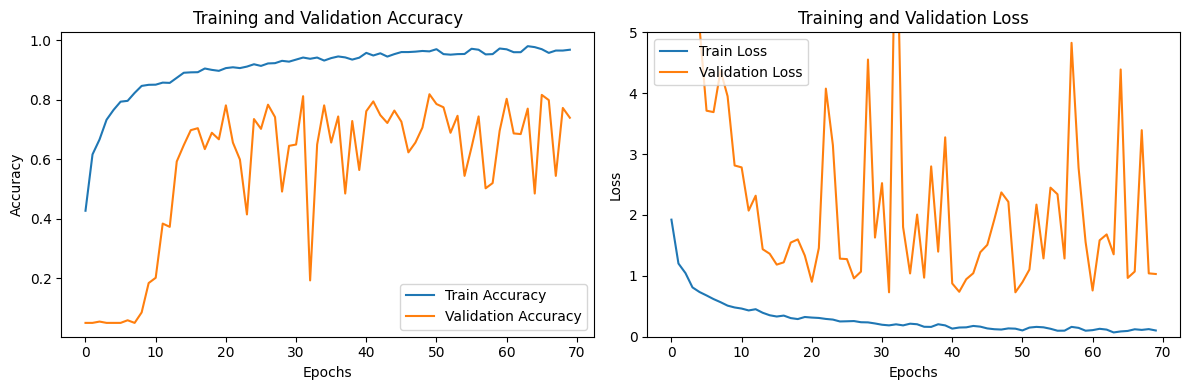

In [ ]:
plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.ylim(0.0, 5.0)
plt.tight_layout()
plt.show()

#Step 9: Evaluating the model on the Test data

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8658 - loss: 0.4245
Test Accuracy: 83.81%
Test Loss: 0.5898


#Step 10: Evaluation Results
Here we get the classification report and the confusion matrix

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
predictions = model.predict(test_generator, verbose=1)


predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_generator.classes


class_labels = list(test_generator.class_indices.keys())


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 284ms/step


In [ ]:
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
                             precision    recall  f1-score   support

       AZURE BREASTED PITTA       0.92      1.00      0.96        23
        African_hunting_dog       0.90      0.69      0.78        26
                Appenzeller       0.68      0.96      0.79        24
        BORNEAN BRISTLEHEAD       0.69      1.00      0.81        24
             Border_terrier       0.90      0.67      0.77        27
                Boston_bull       0.92      0.79      0.85        28
          CARMINE BEE-EATER       0.96      0.96      0.96        25
                  CASSOWARY       0.74      1.00      0.85        25
            CHUCAO TAPACULO       1.00      0.91      0.95        23
                COMMON IORA       0.96      1.00      0.98        22
                   Cardigan       0.54      0.83      0.66        24
           English_springer       0.90      0.72      0.80        25
German_short-haired_pointer       0.78      0.88      0.82        24
          

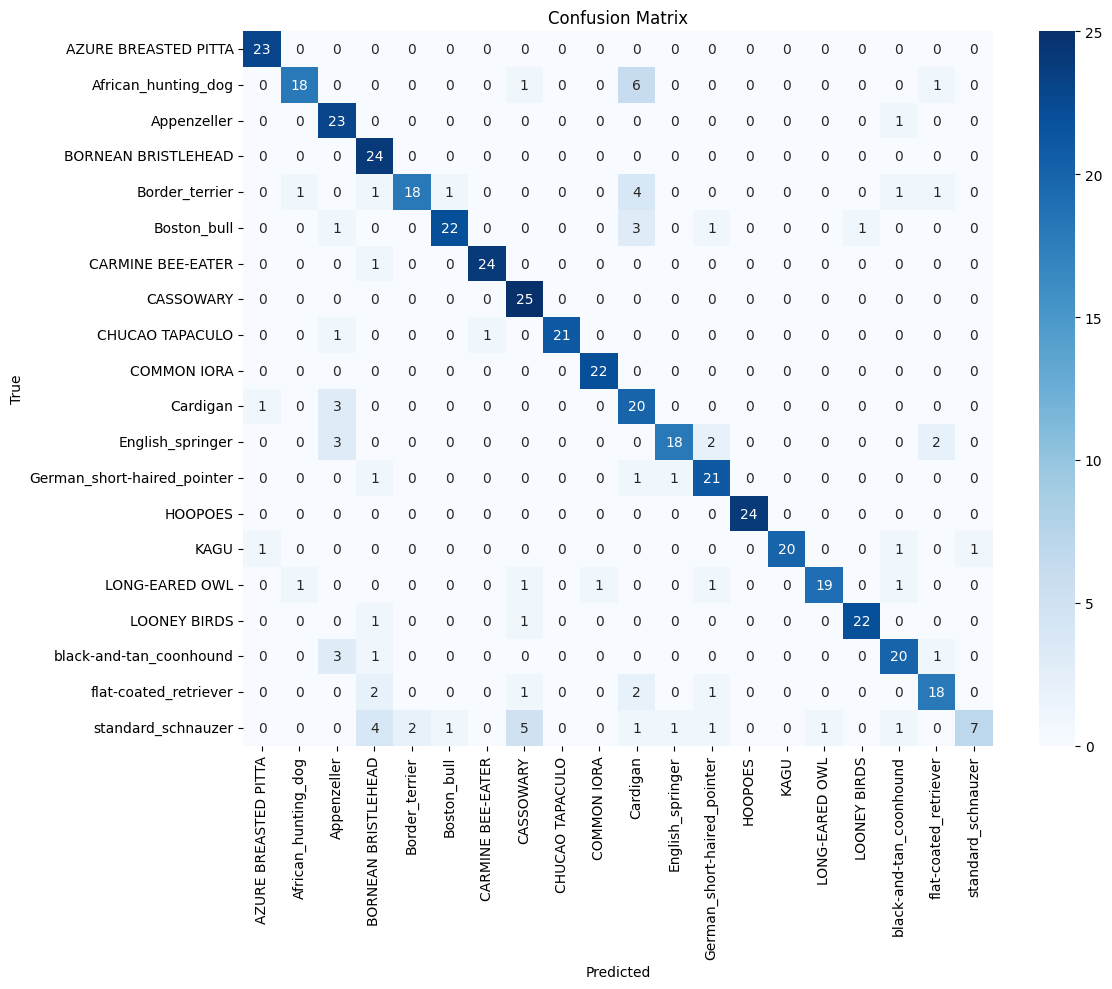

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


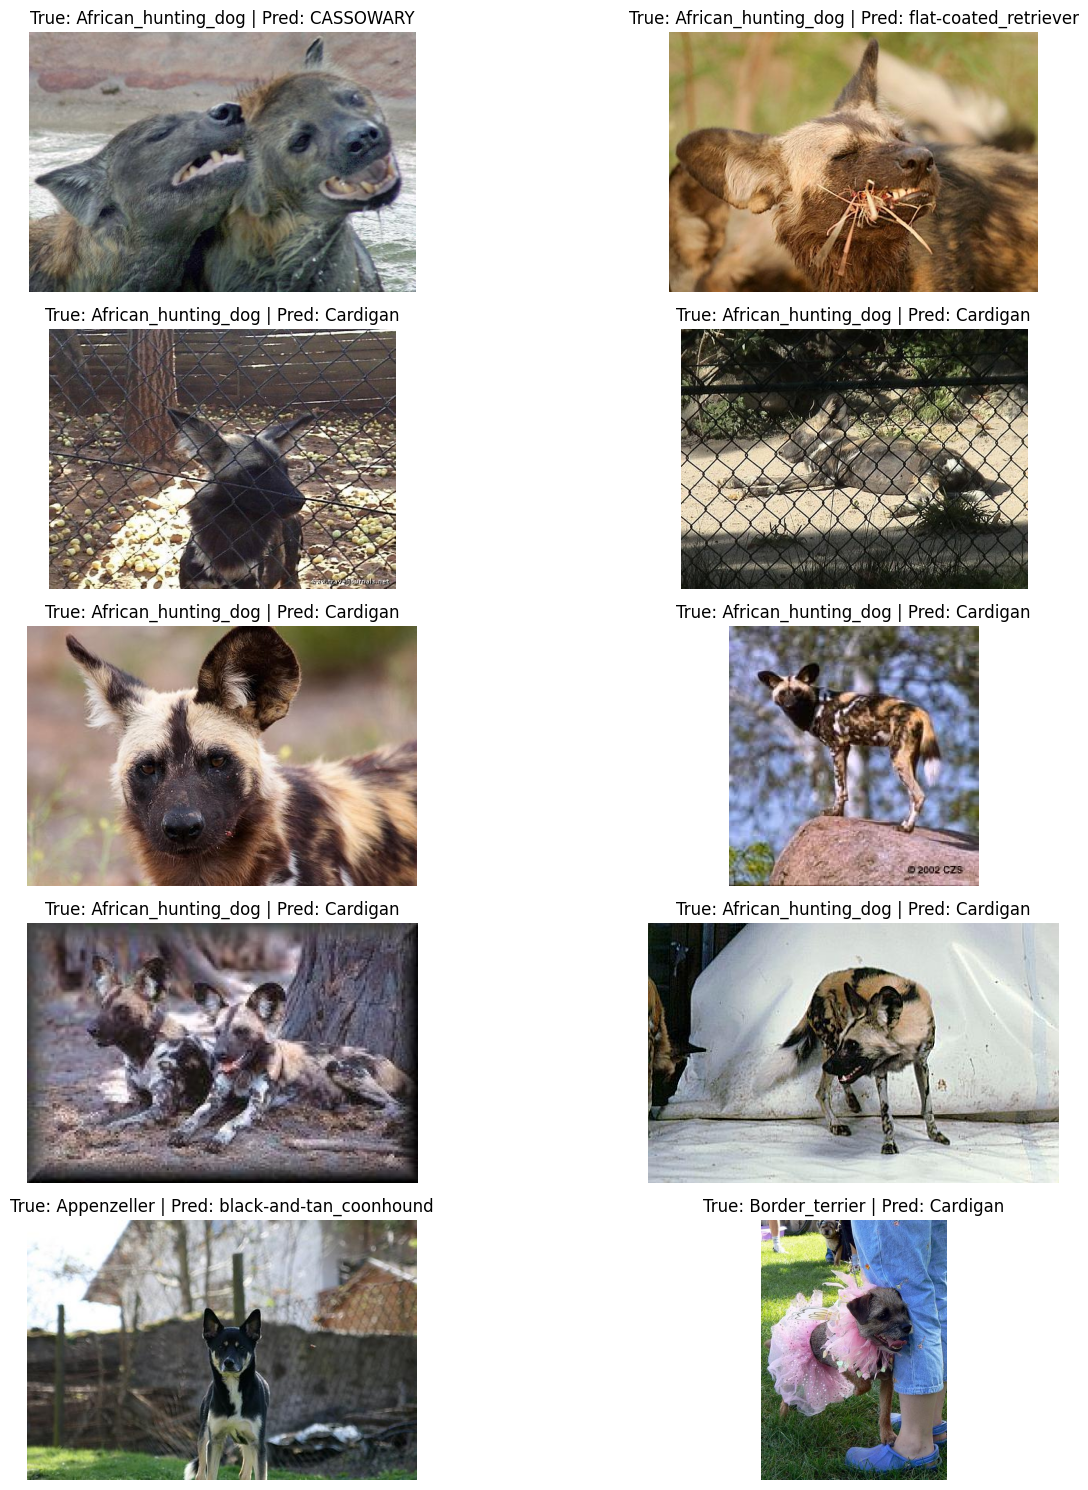

In [ ]:

filenames = test_generator.filenames

misclassified_indices = np.where(predicted_classes != true_classes)[0]


num_to_show = 10
plt.figure(figsize=(15, 15))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    img_path = filenames[idx]
    img = plt.imread(test_generator.directory + '/' + img_path)

    true_label = class_labels[true_classes[idx]]
    predicted_label = class_labels[predicted_classes[idx]]

    plt.subplot(5, 2, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label} | Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

